![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz


In [4]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [5]:
# Celda 1.1
print(bikes.groupby('workingday').total.mean())


workingday
0    188.506621
1    193.011873
Name: total, dtype: float64


De la celda 1.1 se puede observar que el promedio de bicicletas alquiladas no varía mucho entre días laborales y días no laborales

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64


<AxesSubplot:xlabel='hour'>

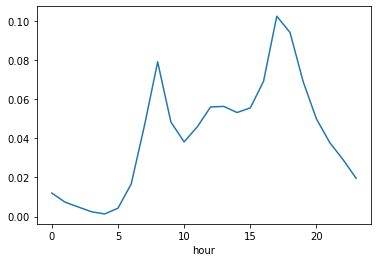

In [6]:
# Celda 1.2
print(bikes.groupby('hour').total.mean())

prop_hora_total = (bikes.groupby('hour').total.sum())
(prop_hora_total / prop_hora_total.sum()).plot()

De la celda 1.2 podemos observar que a las 5 pm y 6 pm el promedio de aquileres es mayor que en cualquier otro horario. 
Más aún, el 20% del total de bicicletas alquiladas tiene lugar en esta franja de horas.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

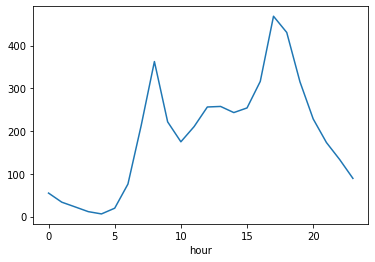

In [7]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

En días no laborales, el pico de alquiler de biciclestas está entre a las 11 am y 3 pm :


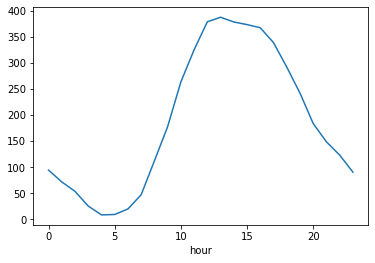

In [9]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
nwd = bikes[bikes["workingday"] == 0]
nwd.groupby('hour').total.mean().plot()

print("En días no laborales, el pico de alquiler de biciclestas está entre a las 11 am y 3 pm :")

En días laborales, existen  dos picos de alquiler de biciclestas: a las 8 am y entre las 5 pm y 6 pm:


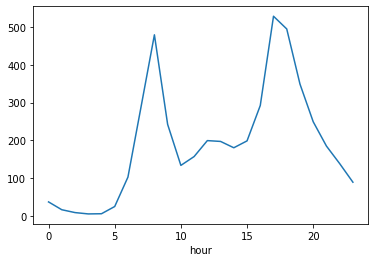

In [8]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
wd = bikes[bikes["workingday"] == 1]
wd.groupby('hour').total.mean().plot()

print("En días laborales, existen  dos picos de alquiler de biciclestas: a las 8 am y entre las 5 pm y 6 pm:")

In [38]:
#print(nwd["total"].describe())
#wd["total"].describe()

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [20]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
print(bikes[["total","hour","workingday"]].corr())
print("Muy poca correlación entre total y workingday")

               total      hour  workingday
total       1.000000  0.400601    0.011594
hour        0.400601  1.000000    0.002780
workingday  0.011594  0.002780    1.000000
Muy poca correlación entre total y workingday


In [33]:
# Celda 3
variables = ["hour","workingday"]
x_1 = bikes[variables]
y_1 = bikes["total"]

reg_lin = linear_model.LinearRegression()

reg_lin.fit(x_1,y_1)
prediccion_1 = reg_lin.predict(x_1)

# Los coeficientes
print('coeficientes: \n', reg_lin.coef_)

# Coef. de determinación
print("Coeficiente de determinación: %.2f" % r2_score(y_1, prediccion_1))

coeficientes: 
 [10.49206282  4.07248627]
Coeficiente de determinación: 0.16


Los coeficientes estiman que por cada hora del día que pasa, aumenta el número de bicicletas alquiladas en 10.5, mientras que si es un día hábil aumenta en 4 el número de alquileres para cada hora.
Existe un grave problema con este modelo y es que no existe una relación líneal entre el número de alquileres y la hora del día. Como vimos en el punto anterior, depende de si el día es hábil o no las horas en que aumenta el alquiler de bicicletas. En todo caso, existe un aumento en las bicicletas alquiladas durante las primeras horas del día y una disminución en las últimas horas del día.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [ ]:
# Celda 5


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [ ]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

In [ ]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9